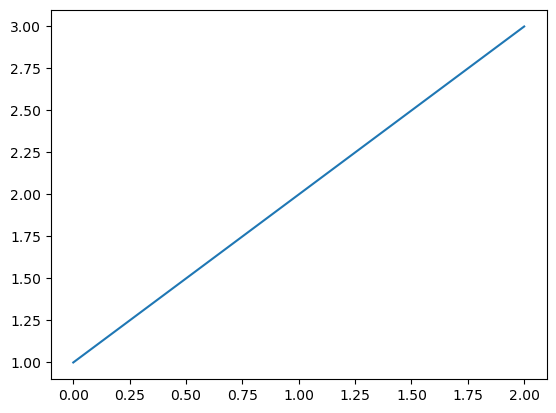

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

In [2]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import re
import torchtext.data  
import numpy as np
import pandas as pd
import string

In [4]:
from torchtext.vocab import FastText as ft
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors
from torchtext.transforms import ToTensor
from torchtext.vocab import Vectors

In [5]:
from pathlib import Path

In [6]:
import unicodedata

## Preparing Data

In [7]:
class Vocab:
    def __init__(self, name):
        self.name = name
        self.stoi = {}
        self.word2count = {}
        self.itos = {0: "<bos>",1: "<pad>", 2:'<eos>',3:'<unk>'}
        self.n_words = 4

    def add_sentence(self, sentence):
        for w in sentence.split(' '):
            self.add_word(w)

    def add_word(self, w):
        if w not in self.stoi:
            self.itos[self.n_words] = w
            self.stoi = {w:i for (i,w) in self.itos.items()}
            self.word2count[w] = 1 
            self.n_words += 1
        else:
            self.word2count[w] += 1
            

In [8]:
path = Path(r'C:/Users/niels/OneDrive/Probabilistic Programming 2022/data/datasets/giga_fren/giga-fren')

In [9]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [10]:
en = (path/'giga-fren.release2.fixed.en').read_text(encoding='utf-8)').replace('\2028','').split('\n')

In [11]:
fr = (path/'giga-fren.release2.fixed.fr').read_text(encoding='utf-8)').replace('\2028','').split('\n')

In [12]:
en_fname = path/'giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren.release2.fixed.fr'

In [13]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

In [14]:
lines = ((re_eq.search(eq), re_fq.search(fq)) for eq, fq in zip(en, fr))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [15]:
en = [normalize_string(q[0]) for q in qs]

In [16]:
fr = [normalize_string(q[1]) for q in qs]

In [17]:
df = pd.DataFrame({'en': en, 'fr': fr}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

In [18]:
df

,en,fr
0,what is light ?,qu est ce que la lumiere ?
1,who are we ?,ou sommes nous ?
2,where did we come from ?,d ou venons nous ?
3,what would we do without it ?,que ferions nous sans elle ?
4,what is the absolute location latitude and lon...,quelle sont les coordonnees latitude et longit...
...,...,...
52326,what are the mechanisms for increasing women s...,quels sont les mecanismes susceptibles d ameli...
52327,why is it still pushed aside silenced or the s...,pourquoi aujourd hui encore ecarte t on cette ...
52328,why should they not demote a judge who rules a...,pourquoi ne devraient ils pas destituer un jug...
52329,why is it that we have achieved judicial indep...,pourquoi avons nous reussi a atteindre l indep...


## Data Frame of pairs en/fr

In [19]:
df = pd.read_csv(path/'questions_easy.csv')

## Limit sentence length to 15 words

In [20]:
df = df.loc[df['en'].apply(lambda x: len(x.split(' '))<=15) & df['fr'].apply(lambda x: len(x.split(' '))<=15)]

In [21]:
df.head()

,en,fr
0,what is light ?,qu est ce que la lumiere ?
1,who are we ?,ou sommes nous ?
2,where did we come from ?,d ou venons nous ?
3,what would we do without it ?,que ferions nous sans elle ?
4,what is the absolute location latitude and lon...,quelle sont les coordonnees latitude et longit...


In [22]:
len(df)

32059

In [23]:
en_vocab = Vocab('en')
fr_vocab = Vocab('fr')

In [24]:
for sent in df['en'].values:
    en_vocab.add_sentence(sent)
    
for sent in df['fr'].values:
    fr_vocab.add_sentence(sent)

In [25]:
vects_fr = Vectors(r'./.vector_cache/wiki.fr.vec')
vects_en = Vectors(r'./.vector_cache/wiki.en.vec')

In [26]:
en_emb = nn.Embedding(len(en_vocab.stoi),300,padding_idx = 1)
wgts = en_emb.weight.data

In [27]:
len(en_vocab.stoi)

11705

In [28]:
miss = []
for w,i in en_vocab.stoi.items():
    try: wgts[i+3] = torch.tensor(vects_en.get_vecs_by_tokens(w))
    except: miss.append(w)       

C:\Users\niels\AppData\Local\Temp\ipykernel_7288\2312731608.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  try: wgts[i+3] = torch.tensor(vects_en.get_vecs_by_tokens(w))


In [29]:
miss

['waves', 'fertilizer', 'sti']

In [95]:
fr_emb = nn.Embedding(len(fr_vocab.stoi),300,padding_idx=1)
wgts = fr_emb.weight.data

In [96]:
miss = []
for w,i in fr_vocab.stoi.items():
    try:wgts[i+1] = torch.tensor(vects_fr.get_vecs_by_tokens(w))
    except: miss.append(w)


C:\Users\niels\AppData\Local\Temp\ipykernel_7288\1027033436.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  try:wgts[i+1] = torch.tensor(vects_fr.get_vecs_by_tokens(w))


In [32]:
miss

['its']

In [97]:
en_tokenizer = get_tokenizer(None, language='en')
fr_tokenizer = get_tokenizer(None, language='fr')

In [98]:
inputs = [[en_vocab.stoi[y] for y in en_tokenizer(x)] for x in df['en'].values]
outputs = [[fr_vocab.stoi[y] for y in en_tokenizer(x)] for x in df['fr'].values]

In [99]:
with torch.no_grad():
    for i in range(4):
        fr_emb.weight[i] = i * torch.ones(300) 
        en_emb.weight[i] = i * torch.ones(300) 

In [100]:
inputs_tensor = ToTensor(padding_value = 1)(inputs)
outputs_tensor = ToTensor(padding_value = 1)(outputs)

In [101]:
inputs_tensor

tensor([[   4,    5,    6,  ...,    1,    1,    1],
        [   8,    9,   10,  ...,    1,    1,    1],
        [  11,   12,   10,  ...,    1,    1,    1],
        ...,
        [   4,  226, 1696,  ...,    1,    1,    1],
        [   4,    9,   19,  ...,    1,    1,    1],
        [   4,   70, 5994,  ...,    1,    1,    1]])

In [102]:
ds = TensorDataset(inputs_tensor,outputs_tensor)

In [103]:
sent = 'how far are we from home <pad> <pad>'
en_tokenizer(sent)

['how', 'far', 'are', 'we', 'from', 'home', '<pad>', '<pad>']

In [104]:
inputs = [en_vocab.stoi[x] for x in en_tokenizer(sent)]
inputs

[362, 3572, 9, 10, 14, 2055, 1, 1]

In [105]:
input_tensor = ToTensor(padding_value=1)(inputs)
input_tensor

tensor([ 362, 3572,    9,   10,   14, 2055,    1,    1])

In [106]:
en_emb(input_tensor)

tensor([[-0.1672, -0.1384,  0.1182,  ...,  0.1266,  0.0362,  0.1928],
        [-0.1799,  0.0375, -0.1555,  ..., -0.1737, -0.0040, -0.3760],
        [-0.2460,  0.0144,  0.3907,  ...,  0.1473,  0.2367,  0.1317],
        ...,
        [-0.0426, -0.2318, -0.2511,  ...,  0.5004,  0.3683, -0.3703],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       grad_fn=<EmbeddingBackward0>)

## Seq-2_Seq without Attention

In [107]:
class Encoder(nn.Module):
    def __init__(self,vocab,embed,hidden_size,n_layers=1,
                dropout=0.5):
        super().__init__()
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.embed = embed
        self.gru = nn.GRU(embed.embedding_dim,hidden_size,n_layers,batch_first=True)
        
    def forward(self,src,hidden=None):
        bs = src.size(0)
        hidden = torch.zeros(1,bs,self.hidden_size)
        
        emb = self.embed(src)
        
        _,h = self.gru(emb,hidden)


        return h

In [108]:
class Decoder(nn.Module):
    def __init__(self,vocab,embed,hidden_size,n_layers=1,
                dropout=0.5):
        super().__init__()
        self.vocab = vocab
        self.vocab_size = len(self.vocab.itos)
        self.hidden_size = hidden_size
        self.embed = embed
        self.gru = nn.GRU(embed.embedding_dim,embed.embedding_dim,batch_first=True)
        self.fc = nn.Linear(embed.embedding_dim,len(vocab.stoi))
        self.dropout = nn.Dropout(0.35)
        
    def forward(self,dec_inp,hidden):

        emb = self.embed(dec_inp)
        outp, h = self.gru(emb,hidden)
        outp = self.fc(self.dropout(outp))
        return outp, h
        

            


In [109]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self,src):
        bs = src.size(0)
        max_len = 15
        
        vocab_size = self.decoder.vocab_size
        
        hidden = self.encoder(src)

        inp = (torch.zeros(src.size(0),1).to(torch.long) + torch.LongTensor([[fr_vocab.stoi['<bos>']]]))

        outputs = []

        for t in range(max_len):

            output,hidden = self.decoder(inp,hidden)
            
            inp = output.argmax(2)

            outputs.append(output)
        
        outputs = torch.stack(outputs)

        return outputs

In [110]:
enc = Encoder(en_vocab,en_emb,300)

In [111]:
enc(input_tensor.unsqueeze(0))

tensor([[[ 0.3830,  0.5155, -0.4655,  0.0063,  0.1398,  0.2488, -0.0172,
          -0.3911,  0.3429, -0.2285,  0.0205,  0.0240,  0.5107, -0.4894,
          -0.0356, -0.1619, -0.2947,  0.2176,  0.5921, -0.5237, -0.1027,
          -0.3049,  0.1317,  0.2611,  0.2493,  0.0706,  0.3127,  0.6242,
          -0.0740,  0.1929, -0.6691,  0.5235,  0.0977,  0.0684, -0.0349,
          -0.0234, -0.0494, -0.2394,  0.1514, -0.1522,  0.2769, -0.2328,
          -0.0715,  0.0167,  0.2569, -0.1763,  0.1054, -0.2423, -0.5408,
           0.3412, -0.2219,  0.4830, -0.1965, -0.2944, -0.3615, -0.3190,
          -0.2632,  0.0430, -0.0431, -0.5093, -0.3181, -0.1193,  0.2776,
          -0.1445, -0.0451, -0.1209,  0.2394,  0.3950, -0.5826, -0.4095,
           0.0255, -0.5743, -0.0076, -0.1472,  0.3422,  0.2426,  0.2184,
           0.0281, -0.0178, -0.1512, -0.0988, -0.4235,  0.2323, -0.0310,
          -0.0556, -0.2998,  0.1272, -0.1977, -0.0948,  0.1879,  0.5041,
          -0.6171, -0.7553, -0.6228,  0.0464,  0.02

In [112]:
dec = Decoder(fr_vocab,fr_emb,300)

In [113]:
model = Seq2Seq(enc,dec)

In [121]:
ds = TensorDataset(inputs_tensor,outputs_tensor)

In [122]:
dl = DataLoader(ds,64,shuffle=True)

In [123]:
def loss_fn(out,tgt):

    return torch.stack([nn.CrossEntropyLoss()(out[i].squeeze(1),tgt.transpose(0,1)[i])\
                        for i in range(tgt.size(1))]).mean()

In [124]:
from torch.optim import Adam

In [125]:
optim = Adam(model.parameters(),lr=0.001)

In [126]:
import time

In [131]:
%%time
epochs = range(100)
epoch_losses = []
for e in epochs:
    losses = []
    for i, (src,tgt) in enumerate(dl):
        
        out = model(src)
        
        loss = loss_fn(out,tgt)
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
        
        losses.append(loss.item())
        
    epoch_loss = np.mean(losses)    
    epoch_losses.append(epoch_loss)
    print(epoch_loss)
        
        

4.264609400145784
3.945262619121346
3.757544036396963
3.5914640778790927
3.4417455634195173
3.2999756298141327
3.1615019296695612
3.032009360319126
2.9071624459858665
2.7906160992300677
2.6816938185168357
2.579764576015358
2.482069679363045
2.3913742018317032
2.3088730737834635
2.2302811802504303
2.155825431475382
2.0883837750333987
2.029121304938417
1.9716570041850656
1.9129666884740193
1.8659256449240649
1.8183707503263584
1.7736111296389154
1.7318315912863451
1.6906863508110275
1.654224448575231
1.6220240297907602
1.5890054800315294
1.554557614459725
1.529941246895019
1.4998260867333935
1.4663161910222675
1.4434654657950183
1.41961904533371
1.3937910299101275
1.3754388983854038
1.3500404443569527
1.3296020823324513
1.3106995065531093
1.289239524843212
1.2647407166734188
1.2524833418651968
1.233708508595259
1.2121103410711307
1.1976487077400833
1.184341675388123
1.1659748506641197
1.1515581087913818
1.1374282378874376
1.1255335675742097
1.1100938232121116
1.0975374668658138
1.0831082

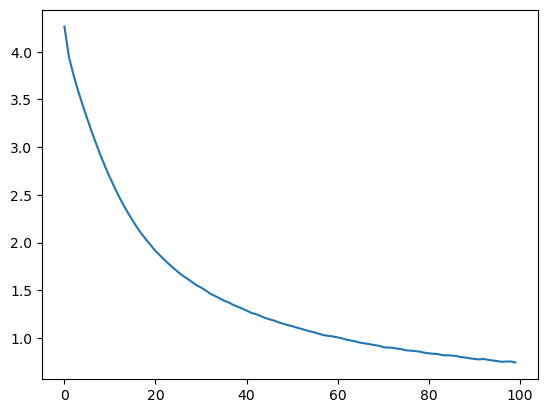

In [132]:
plt.plot(epoch_losses)

In [133]:
src,trg = ds[4]
src,trg = src.unsqueeze(0),trg.unsqueeze(0)

In [134]:
''.join(' '+en_vocab.itos[x] for x in src.squeeze(1).cpu().numpy()[0])

' what is the absolute location latitude and longitude of badger newfoundland and labrador ? <pad>'

In [135]:
''.join(' '+fr_vocab.itos[x] for x in model(src).argmax(3).reshape(1,-1).squeeze(0).cpu().numpy())

' quelle sont les latitude quand et longitude de badger a terre neuve etlabrador ? <pad>'